In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### Neural Network

In [10]:
class PINN(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1))

    def forward(self, x):
        
        return self.net(x)

### Residual loss / boundary condition loss

In [11]:
def residual_loss(model, x):
    
    x = x.detach().requires_grad_(True)
    
    u = model(x)
    # Derivatives
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    residual = u_xx + (np.pi ** 2) * torch.sin(np.pi * x) + (4 * np.pi ** 2) * torch.sin(2*np.pi * x)
    loss_rs = torch.mean(residual**2)
    
    return loss_rs

def boundary_loss(model, x_bc, u_bc):

    u_pred_bc = model(x_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc) ** 2)

    return loss_bc
    

### Training loop

In [12]:
def train_PINN(epochs, model):

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(epochs):
        
        optimizer.zero_grad()
    
        # PDE residual loss
        loss_pde = residual_loss(model, x_domain)
    
        # Boundary condition loss
        loss_bc = boundary_loss(model, x_bc, u_bc)
        
        # Total loss
        loss = loss_pde + loss_bc
        loss.backward()
        optimizer.step()
    
        if (epoch+1) % 500 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

    return model

### Define domain and boundary conditions

In [13]:
# Define domain 
x_domain_ = torch.linspace(0, 1.5, 500).reshape(-1, 1)
x_domain = x_domain_[1:-1]

# Boundary points
x_bc = torch.tensor([[0.0], [1.5]])
u_bc = torch.tensor([[0.0], [-1.0]])

### Train model

In [14]:
# Initialize the PINN model and optimizer
model = PINN()

# Epochs
epochs = 4000

# Training
trained_model = train_PINN(epochs, model)

Epoch 500, Loss: 0.083061
Epoch 1000, Loss: 0.001500
Epoch 1500, Loss: 0.000998
Epoch 2000, Loss: 0.000824
Epoch 2500, Loss: 0.000688
Epoch 3000, Loss: 0.000594
Epoch 3500, Loss: 0.000532
Epoch 4000, Loss: 0.006150


### Visualization

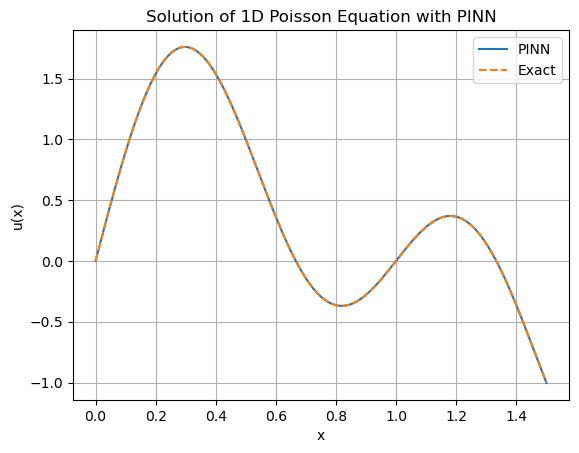

In [15]:
# Model approximation
u_pred = trained_model(x_domain_).detach().numpy()
# Exact solution
u_exact = np.sin(np.pi * x_domain_.numpy()) + np.sin(2*np.pi*x_domain_.numpy())

# Plot
plt.plot(x_domain_, u_pred, label="PINN")
plt.plot(x_domain_, u_exact, '--', label="Exact")
plt.legend()
plt.title("Solution of 1D Poisson Equation with PINN")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.grid(True)
plt.show()